Assignmnet 1: Image Classification with Neural Networks
=====================

Data in Deep Learning
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this assignment, we will use the CIFAR10 dataset.

It has the classes: 

‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Load and normalize CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

## Define the dataset and dataloader

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

def get_vis_loader():
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

def get_train_loader(batch_size, transform):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    return trainloader
    
def get_test_loader(batch_size, transform):
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return testloader
    
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# what's the differenct between visloader and loader?  batchsize! (4 or 64)
vistrainloader, vistestloader = get_vis_loader()
trainloader = get_train_loader(batch_size, transform)
testloader = get_test_loader(batch_size, transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Visualization

Let us show some of the training images, for fun.



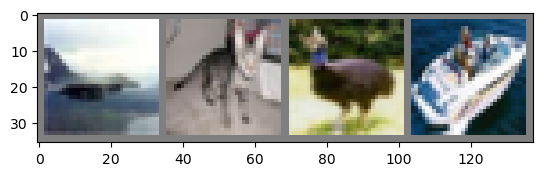

plane   cat  bird  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(vistrainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

fc_net = NeuralNet()

## Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

def get_optimizer(net, lr):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    return optimizer

def accuracy(output, target):
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1]
    return pred.eq(target.view_as(pred)).float().mean()

criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(fc_net, 0.01)

## Define training code

In [7]:
def forward_step(net, inputs, labels):
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return outputs, loss, labels


def train(net, loader, optimizer, max_epoch):
    net.train()
    N = len(loader)
    print_interval = (N // 8 // 100 + 1) * 100
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, loss, labels = forward_step(net, inputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_acc += accuracy(outputs, labels).item()
            if (i + 1) % print_interval == 0:
                print('Epoch: [%d / %d], batches: [%d / %d], loss: %.3f, acc: %.2f' %
                      (epoch + 1, max_epoch, i + 1, N, 
                       running_loss / print_interval, 100 * running_acc / print_interval))
                running_loss = 0.0
                running_acc = 0.0

    print('Finished Training')

## Training on GPU?

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

## Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
train(fc_net, trainloader, optimizer, 5)

## Let's quickly save our trained model:



In [9]:
PATH = './checkpoints/cifar_net.pth'

def save_model(net, path):
    torch.save(net.state_dict(), path)
    
save_model(fc_net, PATH)

## Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



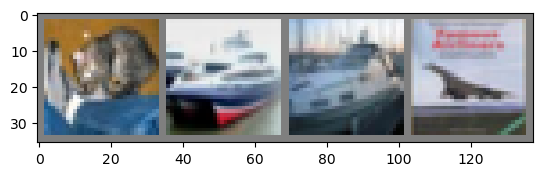

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(vistestloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Load a model
Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [15]:
net = NeuralNet()

def load_model(net, path):
    net.load_state_dict(torch.load(PATH))
    
load_model(net, PATH)

C:\temp\ipykernel_20428\2353817597.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


RuntimeError: Error(s) in loading state_dict for NeuralNet:
	Missing key(s) in state_dict: "fc4.weight", "fc4.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "conv5.weight", "conv5.bias". 
	size mismatch for fc1.weight: copying a param with shape torch.Size([120, 2048]) from checkpoint, the shape in current model is torch.Size([128, 3072]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([120]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([84, 120]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([84]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([10, 84]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([512]).

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


## Define testing code

In [19]:
def test(net, testloader):
    correct = 0
    total = 0
    net.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [15]:
test(net, testloader)

Accuracy of the network on the 10000 test images: 52 %


## See accuracy of each class

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [27]:
def class_test(net, testloader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    net.eval()
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data    
            outputs = net(images)    
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        acc = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                       acc))

In [17]:
class_test(net, testloader)

Accuracy for class plane is: 53.3 %
Accuracy for class car   is: 69.3 %
Accuracy for class bird  is: 38.8 %
Accuracy for class cat   is: 32.0 %
Accuracy for class deer  is: 46.9 %
Accuracy for class dog   is: 48.4 %
Accuracy for class frog  is: 63.3 %
Accuracy for class horse is: 52.2 %
Accuracy for class ship  is: 65.4 %
Accuracy for class truck is: 59.6 %


# Your turn now!

## Define a Convolutional Neural Network

The architecture should be:

    conv2d, 5x5, 3->8, padding=2

    Relu()

    conv2d, 5x5, 8->16, padding=2, stride=2

    Relu()

    conv2d, 5x5, 16->32, padding=2
    
    Relu()

    conv2d, 5x5, 32->64, padding=2, stride=2
    
    Relu()

    conv2d, 5x5, 64->128, padding=2

    maxpool2d

    Relu()

    flatten the feature map

    fc, the whole feature map -> 120

    Relu()

    fc, 120->84

    Relu()

    fc, 84->10
    

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class ConvolutionNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Define a Convolutional Neural Network
        # conv2d, 5x5, 3->8, padding=2, 3 is the three dimension of color RGB.
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2)
        # Relu()

        # conv2d, 5x5, 8->16, padding=2, stride=2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2, stride=2) # now the size is 128*16*16
        # Relu()

        # conv2d, 5x5, 16->32, padding=2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        # Relu()

        # conv2d, 5x5, 32->64, padding=2, stride=2
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=2) # now the size is 128*8*8
        # Relu()

        # conv2d, 5x5, 64->128, padding=2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        # maxpool2d
        self.feature = nn.MaxPool2d(kernel_size=2, stride=2) # now the size is 128*4*4
        # Relu()

        # flatten the feature map

        # fc, the whole feature map -> 120
        self.fc1 = nn.Linear(128*4*4, 120)
        # Relu()

        # fc, 120->84
        self.fc2 = nn.Linear(120, 84)
        # Relu()

        # fc, 84->10
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        pass

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.feature(self.conv5(x)))
        # flatten the feature map
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x
testNN = ConvolutionNet()

############ test code #############
# dataiter = iter(vistestloader)
# images, labels = next(dataiter)
# print(images.size())
# x = images
# x = testNN(x)
# print(x.size())


## Train the convolutional neural network

Train this CNN with learning rate 1e-2 for 5 epochs.

You should see the training loss is aroung 0.9 and accuracy is around 67%.

In [11]:
'''
Implement here, use the train function provided.
'''
# ############## sample code ##################
# def get_optimizer(net, lr):
#     optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
#     return optimizer

# def accuracy(output, target):
#     # get the index of the max log-probability
#     pred = output.max(1, keepdim=True)[1]
#     return pred.eq(target.view_as(pred)).float().mean()
# ##############################################



# ##########################################################################
# def forward_step(net, inputs, labels):
#     outputs = net(inputs)
#     loss = criterion(outputs, labels)
#     return outputs, loss, labels


# def train(net, loader, optimizer, max_epoch):
#     net.train()
#     N = len(loader)
#     print_interval = (N // 8 // 100 + 1) * 100
#     for epoch in range(max_epoch):  # loop over the dataset multiple times

#         running_loss = 0.0
#         running_acc = 0.0
#         for i, data in enumerate(loader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs, loss, labels = forward_step(net, inputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             running_acc += accuracy(outputs, labels).item()
#             if (i + 1) % print_interval == 0:
#                 print('Epoch: [%d / %d], batches: [%d / %d], loss: %.3f, acc: %.2f' %
#                       (epoch + 1, max_epoch, i + 1, N, 
#                        running_loss / print_interval, 100 * running_acc / print_interval))
#                 running_loss = 0.0
#                 running_acc = 0.0

#     print('Finished Training')
# ###################################################################
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(testNN, 0.01)
train(testNN, trainloader, optimizer, 5)
# question: I trained for around 10 epochs to get 67% acc.

Epoch: [1 / 5], batches: [100 / 782], loss: 1.753, acc: 39.73
Epoch: [1 / 5], batches: [200 / 782], loss: 1.743, acc: 39.72
Epoch: [1 / 5], batches: [300 / 782], loss: 1.746, acc: 39.28
Epoch: [1 / 5], batches: [400 / 782], loss: 1.708, acc: 40.20
Epoch: [1 / 5], batches: [500 / 782], loss: 1.681, acc: 42.16
Epoch: [1 / 5], batches: [600 / 782], loss: 1.679, acc: 41.66
Epoch: [1 / 5], batches: [700 / 782], loss: 1.656, acc: 42.78
Epoch: [2 / 5], batches: [100 / 782], loss: 1.612, acc: 44.30
Epoch: [2 / 5], batches: [200 / 782], loss: 1.608, acc: 43.72
Epoch: [2 / 5], batches: [300 / 782], loss: 1.576, acc: 45.28
Epoch: [2 / 5], batches: [400 / 782], loss: 1.546, acc: 46.70
Epoch: [2 / 5], batches: [500 / 782], loss: 1.541, acc: 46.69
Epoch: [2 / 5], batches: [600 / 782], loss: 1.510, acc: 47.44
Epoch: [2 / 5], batches: [700 / 782], loss: 1.517, acc: 47.44
Epoch: [3 / 5], batches: [100 / 782], loss: 1.374, acc: 53.27
Epoch: [3 / 5], batches: [200 / 782], loss: 1.344, acc: 53.98
Epoch: [

In [21]:
PATH = './checkpoints/cnn_net.pth'

def save_model(net, path):
    torch.save(net.state_dict(), path)
    
save_model(testNN, PATH)



## Test the convolutional neural network

Test this CNN on the test dataset.

You should see the accuracy is around 62%.

In [25]:
def load_model(net, path):
    net.load_state_dict(torch.load(path))

PATH = './checkpoints/cnn_net.pth'
net = ConvolutionNet()   
load_model(net, PATH)
test(net, testloader)

C:\temp\ipykernel_20428\912888988.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path))


Accuracy of the network on the 10000 test images: 62 %


## Accuracy (each class) of CNN

Test this CNN on the test dataset to see the accuracy of each class.

In [28]:
class_test(net, testloader)

Accuracy for class plane is: 59.5 %
Accuracy for class car   is: 77.0 %
Accuracy for class bird  is: 52.7 %
Accuracy for class cat   is: 64.0 %
Accuracy for class deer  is: 49.0 %
Accuracy for class dog   is: 44.6 %
Accuracy for class frog  is: 70.3 %
Accuracy for class horse is: 58.6 %
Accuracy for class ship  is: 73.8 %
Accuracy for class truck is: 74.3 %


## Let's use BN

Add BatchNorm2d to the convolution neural network you implemented.

You should add batchnorm after the convolution operator and before the activation layer.

Please train this network and show the test accuracy.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionBNNet(nn.Module):
    def __init__(self):
        super().__init__()
        ## Define a Convolutional Neural Network
        # conv2d, 5x5, 3->8, padding=2, 3 is the three dimension of color RGB.
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(8*5*32*32)
        # Relu()

        # conv2d, 5x5, 8->16, padding=2, stride=2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2, stride=2) # now the size is 16*16*16
        self.batchnorm2 = nn.BatchNorm2d(16*5*16*16)
        # Relu()

        # conv2d, 5x5, 16->32, padding=2
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(32*5*16*16)
        # Relu()

        # conv2d, 5x5, 32->64, padding=2, stride=2
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, padding=2, stride=2) # now the size is 64*8*8
        self.batchnorm4 = nn.BatchNorm2d(64*5*8*8)
        # Relu()

        # conv2d, 5x5, 64->128, padding=2
        self.conv5 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.batchnorm5 = nn.BatchNorm2d(64*5*8*8)
        # maxpool2d
        self.feature = nn.MaxPool2d(kernel_size=2, stride=2) # now the size is 128*4*4
        # Relu()

        # flatten the feature map

        # fc, the whole feature map -> 120
        self.fc1 = nn.Linear(128*4*4, 120)
        # Relu()

        # fc, 120->84
        self.fc2 = nn.Linear(120, 84)
        # Relu()

        # fc, 84->10
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        pass

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.feature(self.conv5(x)))
        # flatten the feature map
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x


## Train the CNN with BN

Train this CNN with learning rate 1e-2 for 5 epochs.

In [ ]:
pass
'''
Implement here
'''

## Test the CNN with BN

Test this CNN on the test dataset.

In [ ]:
'''
Implement here
'''

## Accuracy (each class) of CNN with BN

Test this CNN with BNN on the test dataset to see the accuracy of each class.

In [ ]:
'''
Implemente here, use the class_test function provided.
'''

## Design by yourself
Now, based on the knowledge learned in class or by referring to online resources, you can design your own network architecture or incorporate other optimization methods to improve task performance. Please provide at least one improvement strategy.

In [ ]:
'''
Implement here
'''

## Good Job!